# CTA simulation tools

## Introduction

In this tutorial we will simulate the expected counts of a Fermi/LAT source in the CTA energy range.

We will go through the following topics: 

- handling of Fermi/LAT 3FHL catalogue with [gammapy.catalog.SourceCatalog3FHL](http://docs.gammapy.org/dev/catalog/)
- handling of EBL tables with [gammapy.spectrum.TableModel](http://docs.gammapy.org/dev/api/gammapy.spectrum.models.TableModel.html#gammapy.spectrum.models.TableModel)
- handling of CTA responses with [gammapy.scripts.CTAPerf](http://docs.gammapy.org/dev/api/gammapy.scripts.CTAPerf.html?highlight=ctaperf)
- simulation of an observation for a given set of parameters with [gammapy.scripts.CTAObservationSimulation](http://docs.gammapy.org/dev/api/gammapy.scripts.CTAObservationSimulation.html#gammapy.scripts.CTAObservationSimulation)
- Illustration of Sherpa power to fit an observation with a user model (coming soon)
 
## Setup

In order to deal with plots we will begin with matplotlib import:  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

## PKS 2155-304 selection from the 3FHL Fermi/LAT catalogue
We will start by selecting the source PKS 2155-304 in the 3FHL Fermi/LAT catalogue for further use.

In [2]:
from gammapy.catalog import SourceCatalog3FHL

# load catalogs
fermi_3fhl = SourceCatalog3FHL()
name = 'PKS 2155-304'
source = fermi_3fhl[name]

We can then access the caracteristics of the source via the `data` attribut and select its spectral model for further use. 

In [3]:
redshift = source.data['Redshift']
src_spectral_model = source.spectral_model

Here is an example on how to plot the source spectra

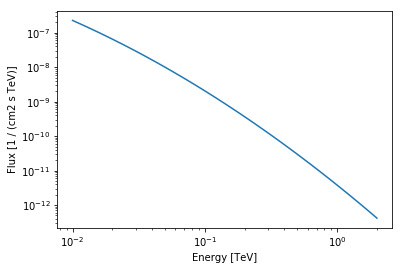

In [4]:
# plot the Fermi/LAT model
import astropy.units as u
src_spectral_model.plot(energy_range=[10 * u.GeV, 2 *u.TeV])

## Select a model for EBL absorption
We will need to modelise EBL (extragalactic background light) attenuation to have get a 'realistic' simulation. Different models are available in GammaPy. Here is an example on how to deal with the absorption coefficients. 

In [5]:
from gammapy.spectrum.models import Absorption

# Load models for PKS 2155-304 redshift 
dominguez = Absorption.read_builtin('dominguez').table_model(redshift)
franceschini = Absorption.read_builtin('franceschini').table_model(redshift)
finke = Absorption.read_builtin('finke').table_model(redshift)

From here you can have access to the absorption coefficient for a given energy.

In [6]:
energy = 1 * u.TeV
abs_value = dominguez.evaluate(energy=energy, scale=1)
print('absorption({} {}) = {}'.format(energy.value, energy.unit, abs_value))

absorption(1.0 TeV) = 0.2877190690093156


Below is an example to plot EBL absorption for different models 

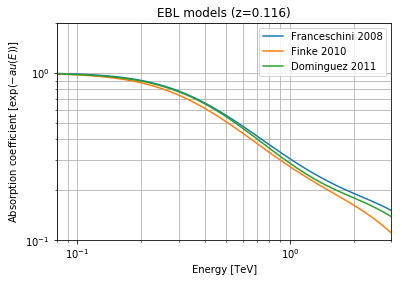

In [7]:
# start customised plot
energy_range = [0.08, 3] * u.TeV
ax = plt.gca()
opts = dict(energy_range=energy_range, energy_unit='TeV', ax=ax)
franceschini.plot(label='Franceschini 2008', **opts)
finke.plot(label='Finke 2010', **opts)
dominguez.plot(label='Dominguez 2011', **opts)

# tune plot
ax.set_ylabel(r'Absorption coefficient [$\exp{(-        au(E))}$]')
ax.set_xlim(energy_range.value)  # we get ride of units
ax.set_ylim([1.e-1, 2.])
ax.set_yscale('log')
ax.set_title('EBL models (z=' + str(redshift) + ')')
plt.grid(which='both')
plt.legend(loc='best') # legend

# show plot
plt.show()


## CTA instrument response functions
Here we are going to deal with CTA point-like instrument response functions (public version, production 2). Data format for point-like IRF is still missing. For now, a lot of efforts is made to define full-containment IRFs (https://gamma-astro-data-formats.readthedocs.io/en/latest/irfs/index.html). In the meantime a temporary format is used in gammapy. It will evolved.

To simulate one observation we need the following IRFs: 
 - effective area as a function of true energy (energy-dependent theta square cute)
 - background rate as a function of reconstructed energy (energy-dependent theta square cute)
 - migration matrix, e_reco/e_true as a function of true energy
 
To handle CTA's responses we will use the `CTAPerf` class

/home/kingj/Software/miniconda3/envs/headversions/lib/python3.5/site-packages/astropy-3.0.dev20201-py3.5-linux-x86_64.egg/astropy/units/quantity.py:1053: RuntimeWarning: invalid value encountered in true_divide
  return super().__truediv__(other)


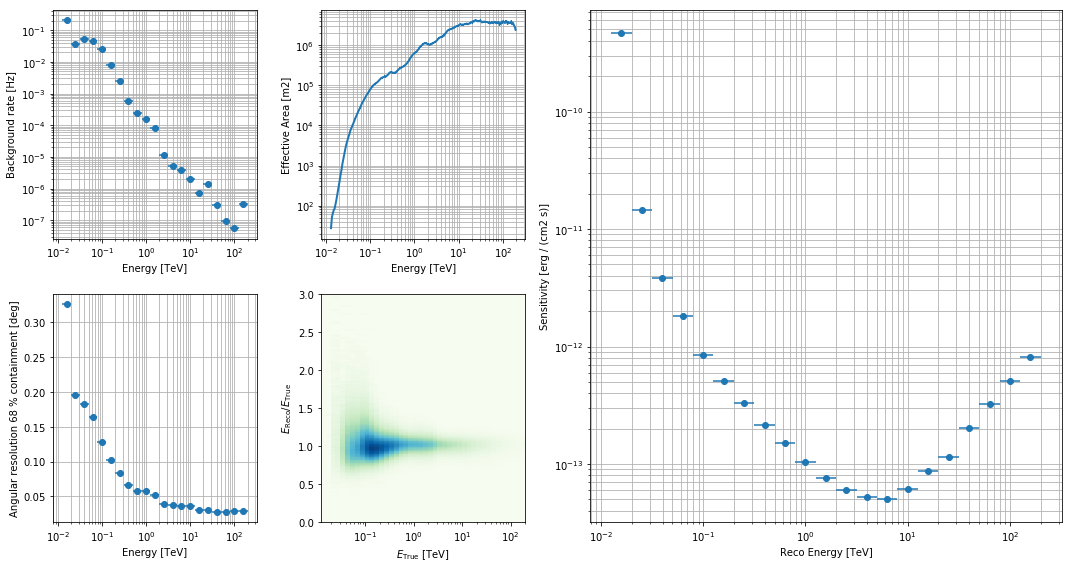

In [8]:
from gammapy.scripts import CTAPerf
# South array optimisation for faint source 
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_50h.fits.gz'
cta_perf = CTAPerf.read(filename)
cta_perf.peek()

Different optimisations are available for different type of source (bright, 0.5h; medium, 5h; faint, 50h). Here is an example to have a quick look to the different optimisation

/home/kingj/Software/miniconda3/envs/headversions/lib/python3.5/site-packages/astropy-3.0.dev20201-py3.5-linux-x86_64.egg/astropy/units/quantity.py:1053: RuntimeWarning: invalid value encountered in true_divide
  return super().__truediv__(other)


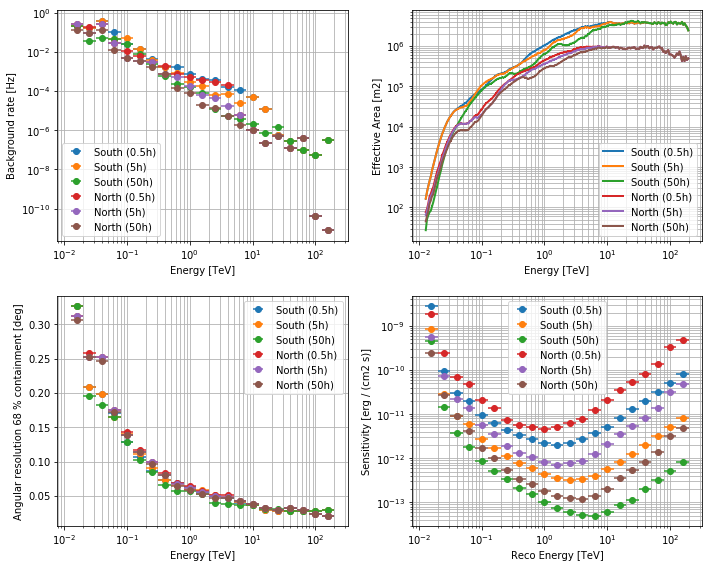

In [9]:
prod_dir = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/'
opti = ['0.5h', '5h', '50h']
site = ['South', 'North']
cta_perf_list = []  # will be filled with different performance
labels = []  # will be filled with different performance labels for the legend
for isite in site: 
    for iopti in opti:
        filename = prod_dir + '/' + isite + '_' + iopti + '.fits.gz'
        cta_perf = CTAPerf.read(filename)
        cta_perf_list.append(cta_perf)
        labels.append(isite + ' (' + iopti + ')')

CTAPerf.superpose_perf(cta_perf_list, labels)

## CTA simulation of an observation
Now we are going to simulate the expected counts in the CTA energy range. To do so we will need to specify a target (caracteristics of the source) and the parameters of the observation (such as time, ON/OFF normalisation, etc.)

### Target definition

In [10]:
# define target spectral model absorbed by EBL
from gammapy.spectrum.models import Absorption, AbsorbedSpectralModel

absorption = Absorption.read_builtin('dominguez')
spectral_model = AbsorbedSpectralModel(
    spectral_model=src_spectral_model,
    absorption=absorption,
    parameter=redshift,
)
# define target
from gammapy.scripts.cta_utils import Target
target = Target(
    name=source.data['Source_Name'],  # from the 3FGL catalogue source class
    model=source.spectral_model,  # defined above
)
print(target)

*** Target parameters ***
Name=3FHL J2158.8-3013 
amplitude=7.707001703494143e-11 1 / (cm2 GeV s)
reference=18.31732177734375 GeV
alpha=1.8807274103164673 
beta=0.14969758689403534 



### Observation definition

In [11]:
from gammapy.scripts.cta_utils import ObservationParameters
alpha = 0.2 * u.Unit('')  # normalisation between ON and OFF regions
livetime = 5. * u.h
# energy range used for statistics (excess, significance, etc.)
emin, emax = 0.05 * u.TeV, 5 * u.TeV
params = ObservationParameters(
    alpha=alpha, livetime=livetime,
    emin=emin, emax=emax,
)
print(params)

*** Observation parameters summary ***
alpha=0.2 []
livetime=5.0 [h]
emin=0.05 [TeV]
emax=5.0 [TeV]



### Performance

In [12]:
from gammapy.scripts import CTAPerf
# PKS 2155-304 is 10 % of Crab at 1 TeV ==> intermediate source
filename = '$GAMMAPY_EXTRA/datasets/cta/perf_prod2/point_like_non_smoothed/South_5h.fits.gz'
perf = CTAPerf.read(filename)

/home/kingj/Software/miniconda3/envs/headversions/lib/python3.5/site-packages/astropy-3.0.dev20201-py3.5-linux-x86_64.egg/astropy/units/quantity.py:1053: RuntimeWarning: invalid value encountered in true_divide
  return super().__truediv__(other)


### Simulation

Here we are going to simulate what we expect to see with CTA and measure the duration of the simulation

In [13]:
from gammapy.scripts.cta_utils import CTAObservationSimulation

simu = CTAObservationSimulation.simulate_obs(
    perf=perf,
    target=target,
    obs_param=params,
)

# print simulation results
print(simu)

*** Observation summary report ***
Observation Id: 0
Livetime: 5.000 h
On events: 9619
Off events: 10400
Alpha: 0.200
Bkg events in On region: 2080.00
Excess: 7539.00
Excess / Background: 3.62
Gamma rate: 2.51 1 / min
Bkg rate: 0.69 1 / min
Sigma: 102.67
energy range: 0.05 TeV - 5.01 TeV


Now we can take a look at the excess, ON and OFF distributions

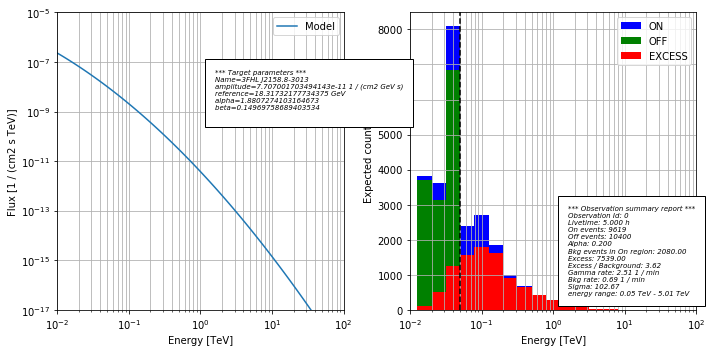

In [14]:
CTAObservationSimulation.plot_simu(simu, target)

We can access simulation parameters via the [gammapy.spectrum.SpectrumStats](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumStats.html#gammapy.spectrum.SpectrumStats) attribute of the [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/dev/api/gammapy.spectrum.SpectrumObservation.html#gammapy.spectrum.SpectrumObservation) class:

In [15]:
stats = simu.total_stats_safe_range
stats_dict = stats.to_dict()
print('excess: {}'.format(stats_dict['excess']))
print('sigma: {:.1f}'.format(stats_dict['sigma']))

excess: 7539.0
sigma: 102.7


Finally, you can get statistics for every reconstructed energy bin with: 

In [16]:
table = simu.stats_table()
# Here we only print part of the data from the table
table[['energy_min', 'energy_max', 'excess', 'background', 'sigma']][:10]

/home/kingj/Software/gammapy/gammapy/stats/poisson.py:382: RuntimeWarning: divide by zero encountered in double_scalars
  tt = (alpha + 1) / (n_on + n_off)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:383: RuntimeWarning: invalid value encountered in multiply
  ll = n_on * np.log(n_on * tt / alpha)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: invalid value encountered in multiply
  mm = n_off * np.log(n_off * tt)
/home/kingj/Software/gammapy/gammapy/stats/poisson.py:384: RuntimeWarning: divide by zero encountered in log
  mm = n_off * np.log(n_off * tt)


energy_min,energy_max,excess,background,sigma
TeV,TeV,,,
float64,float64,float64,float64,float64
0.0125892544165,0.0199526231736,124.4,3701.6,1.85449984597
0.0199526231736,0.0316227786243,504.0,3128.0,7.98444463023
0.0316227786243,0.0501187257469,1244.8,6838.2,13.2886502977
0.0501187257469,0.0794328227639,1569.4,818.6,38.9772009509
0.0794328227639,0.125892549753,1803.2,899.8,42.3713164745
0.125892549753,0.199526235461,1621.6,238.4,54.9220066511
0.199526235461,0.316227763891,919.0,72.0,46.0016063352
0.316227763891,0.501187205315,648.2,27.8,41.576728621


## Exercises

- do the same thing for the source 1ES 2322-40.9 (faint BL Lac object)
- repeat the procedure 10 times and average detection results (excess and significance)
- estimate the time needed to have a 5-sigma detection for Cen A (core)

## What next?

In this tutorial we learned how to simulate the expected counts of a Fermi/LAT source in the CTA energy range. 
Here's some suggestions where to go next:

* in order to fit a model to the simulted spectra, have a look at the last section of [this tutorial](http://docs.gammapy.org/dev/notebooks/spectrum_analysis.html) or [this tutorial](http://docs.gammapy.org/dev/notebooks/spectrum_fitting_with_sherpa.html)